{'epoch': 27, 'step': 35850, 'mlm_loss': 2.639171406075113, 'nsp_loss': 0.5908688577406539, 'mlm_valid_loss': 4.0372061913548425, 'nsp_valid_loss': 0.7008545153159973, 'mlm_valid_acc': 0.38975122859398004, 'nsp_valid_acc': 0.6052732044444759}


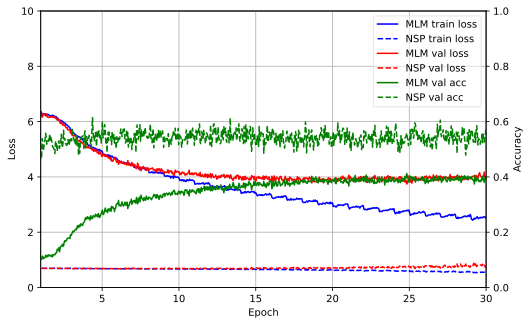

In [1]:
# Platform
DISPLAY = True  # if script is ran on Tongji HPC conda env, then no display
MACOS = False  # if script is ran on MACOS; default: Linux

# Imports
import torch
import torch.nn as nn
import os
import random
import collections
import time
import numpy as np
import math
import inspect
import json
import csv
import pickle
if DISPLAY:
    import matplotlib.pyplot as plt
    from matplotlib_inline import backend_inline
    from IPython import display
    from transformers import get_linear_schedule_with_warmup

# Data settings
TRAIN_DATA = "data/wikitext-2-v1/wiki.train.tokens"
VALID_DATA = "data/wikitext-2-v1/wiki.valid.tokens"
TEST_DATA = "data/wikitext-2-v1/wiki.test.tokens"
NUM_CPUS = 8  # number of threads to be used for data processing
vocab_dir = 'vocab_500mb_30000.pkl'  # vocab generated using 500MB text file; vocab has 30000+ subwords
tokenizer_name = 'BPETokenizer'  # alternatives: BPETokenizer, WordTokenizer
data_loader_shuffle = True

# Hyperparameters
batch_size = 32
max_len = 90  # for word tokenization, recommend: 64; for BPE, recommend: 90
num_epochs = 30  # recommend: 30
learning_rate = 1e-4  # recommend: 1e-4 for medium dataset
weight_decay = 1e-5  # recommend: 1e-5 for medium dataset
num_hiddens = 256  # number of hidden units in Transformer encoder; 768 for BERT-base; recommend: 768
# = num_heads * query_embedding_dim (= key_embedding_dim = value_embedding_dim)
ffn_num_hiddens = 512  # number of hidden units of Pointwise FFN for Transformer encoder; Cf. DIDL, p442; recommend: 1024
num_heads = 2  # num_heads should divide num_hiddens; eg. 768 / 12 = 64; 12 for BERT-base; recommend: 6
num_blks = 2  # number of Transformer encoder blocks; 12 for BERT-base; redommend: 6
dropout = 0.1  # recommend: 0.2
betas = (0.9, 0.999)  # parameter for Adam; default: (0.9, 0.999)
alpha = 1.0  # Scale the MLM loss relative to NSP loss
clip_grad = False  # clip gradient
clip_grad_max_norm = 1.0  # max norm if clip_grad is True
custom_init = False  # use custom initialization
use_warmup_lr_scheduler = False  # use warmup learning rate scheduler (10% warmup)
use_lr_scheduler = False  # use Adam with linear learning rate decay
lr_scheduler_step_size = 5000  # step size for linear learning rate decay
lr_scheduler_gamma = 0.8  # gamma for linear learning rate decay
loss = nn.CrossEntropyLoss()
loss_reduction_none = nn.CrossEntropyLoss(reduction='none')

# Visualization
plot_every = 50  # plot every n batches; recommend: 500
validation_batchs = 10  # number of batches to be used for validation; recommend: 50
y1_limit = [0, 10]  # axis limit for y1
y2_limit = [0, 1]  # axis limit for y2
smoothing_coeff = 0.75






# Devices
def try_all_gpus():
    """
    Return all available GPUs, or [cpu(),] if no GPU exists.
    """
    num_gpus = torch.cuda.device_count()
    return [torch.device(f'cuda:{i}') for i in range(num_gpus)]
if not MACOS:
    devices = try_all_gpus()
else:
    devices = [torch.device('mps')]



# Utilities
def create_object(class_name, *args):
    # Assuming the class is defined globally
    class_ = globals().get(class_name)
    if class_:
        return class_(*args)
    else:
        raise ValueError(f"Class '{class_name}' is not defined.") 

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """
        Save function arguments into class attributes.
        """
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)


class MyModule(nn.Module, HyperParameters):  
    """
    The base class of models.
    """
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        #self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
        # 需要定义一个net，然后forward则调用这个net；
        # net也是一个nn.Module，所以net的forward方法就是nn.Module的forward方法；
        # 当然，其实很多模型会直接override forward method，而非定义net；如p197例子
        

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """
        """
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


# Helper function
def set_axes(axes, xlabel,xlim, ylim, xscale, yscale, show_grid=False):
    """
    Set the axes for matplotlib.
    """
    if xlabel: axes.set_xlabel(xlabel)
    if xscale: axes.set_xscale(xscale)
    if yscale: axes.set_yscale(yscale)
    if xlim: axes.set_xlim(xlim)
    if ylim: axes.set_ylim(ylim)
    if xlim: axes.set_xlim(xlim)
    if ylim: axes.set_ylim(ylim)
    axes.grid(show_grid)

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, y1_label=None, y2_label=None, y1_legend=None, y2_legend=None, xlim=None,
                 y1_lim=None, y2_lim=None, xscale='linear', y1_scale='linear', y2_scale='linear',
                 fmts=('b-', 'b--', 'r-', 'r--', 'g-', 'g--'), figsize=(8, 5)):
        """
        Parameters:
            fmts: formats of plots
        """
        if DISPLAY:
            # Incrementally plot multiple lines
            use_svg_display()
            self.fig, self.axes1 = plt.subplots(1, 1, figsize=figsize)
            self.axes2 = self.axes1.twinx()
        self.y1_label = y1_label
        self.y2_label = y2_label
        self.y1_legend = y1_legend
        self.y2_legend = y2_legend
        # Use a lambda function to capture arguments
        self.config_axes1 = lambda: set_axes(self.axes1, xlabel, xlim, y1_lim, xscale, y1_scale, show_grid=True)
        self.config_axes2 = lambda: set_axes(self.axes2, xlabel, xlim, y2_lim, xscale, y2_scale)
        self.X1, self.X2, self.Y1, self.Y2, self.fmts = None, None, None, None, fmts

    def add(self, x, y1, y2):
        # Add multiple data points into the figure
        # y1, y2 are list of values
        # Note: y1 and y2 have different y-axis
        
        # data accumulation
        n1 = len(y1)  # number of curves with axis on the left
        n2 = len(y2)  # number of curves with axis on the right
        if not hasattr(x, "__len__"):  # if x is a scalar
            x1 = [x] * n1
            x2 = [x] * n2
        # X1, X2, Y1, Y2 are records of data over all steps
        if self.X1 == None:
            self.X1 = [[] for _ in range(n1)]
        if self.X2 == None:
            self.X2 = [[] for _ in range(n2)]
        if self.Y1 == None:
            self.Y1 = [[] for _ in range(n1)]
        if self.Y2 == None:
            self.Y2 = [[] for _ in range(n2)]
        # append data of current step to X1, X2, Y1, Y2
        for i, (a, b) in enumerate(zip(x1, y1)):
            if a is not None and b is not None:
                self.X1[i].append(a)  # accumulate data for curves
                self.Y1[i].append(b)
        for i, (a, b) in enumerate(zip(x2, y2)):
            if a is not None and b is not None:
                self.X2[i].append(a)
                self.Y2[i].append(b)
        
        if DISPLAY:
            # axes settings and plot
            self.axes1.cla()
            self.axes2.cla()
            self.fmts1 = self.fmts[:n1]
            self.fmts2 = self.fmts[n1:]
            self.axes1.set_ylabel(self.y1_label)
            self.axes2.set_ylabel(self.y2_label)
            # Ensure second y-axis is on the right side
            self.axes2.yaxis.set_label_position('right')
            self.axes2.yaxis.tick_right()
            for i, (x, y, fmt) in enumerate(zip(self.X1, self.Y1, self.fmts1)):
                self.axes1.plot([item / num_steps_per_epoch for item in x], y, fmt, label=self.y1_legend[i])
            for i, (x, y, fmt) in enumerate(zip(self.X2, self.Y2, self.fmts2)):
                self.axes2.plot([item / num_steps_per_epoch for item in x], y, fmt, label=self.y2_legend[i])
            self.config_axes1()
            self.config_axes2()
            # Combine legends
            lines_1, labels_1 = self.axes1.get_legend_handles_labels()
            lines_2, labels_2 = self.axes2.get_legend_handles_labels()
            self.axes2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', framealpha=0.5)
            # Adjust layout to avoid label overlap
            #plt.tight_layout()
            
            # show plots
            display.display(self.fig)
            display.clear_output(wait=True)


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')
    
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

def accuracy_nsp(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def accuracy_mlm(y_hat, y, weights):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
        
    cmp = astype(y_hat, y.dtype) == y
    cmp = cmp * (weights.reshape(-1))
    return float(reduce_sum(astype(cmp, y.dtype)))









# Transformer encoder
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

class Encoder(nn.Module):
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

class MultiHeadAttention(MyModule):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        # 注意：p = p_q = p_k = p_v = p_out / h
        # 即nu_hidden必须要能够整除 num_heads
        # Cf. Dive into deep learning, p434
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
    
    
    
    
    
    
    

# BERT model
class BERTEncoder(nn.Module):
    """
    BERT encoder.
    """
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

class MaskLM(nn.Module):
    """
    The masked language model task of BERT.
    """
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

class NextSentencePred(nn.Module):
    """
    The next sentence prediction task of BERT.
    """
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

class BERTModel(nn.Module):
    """
    The BERT model.
    """
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    """
    loss function for BERT batch sample
    """
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss_reduction_none(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1)
    # mlm_weights are used to mask <pad>'s loss since they are not used for prediction
    # Note: mlm_l is averaged over valid prediction positions of whole batch in the loss function
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    # Note: nsp_l is averaged over batch in the loss function
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + alpha * nsp_l
    return mlm_l, nsp_l, l








# Data processing methods
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """
    add <cls> and <sep> tokens to sentences
    """
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

def _get_next_sentence(sentence, next_sentence, paragraphs):
    """
    generate examples for next sentence prediction task
    inputs are the true sentence and the next sentence
    """
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    """
    get next sentence prediction examples
    
    invoke get_tokens_and_segments to add <cls> and <sep> tokens
    invoke nsp_data_from_paragrap to get examples
    需要输入paragraphs，因为生成heg example的时候，需要从这里面随机选取一个
    """
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            # Note: too long sentences will be skipped!!
            # for the same max_len, subword tokenization will
            # result in much smaller dataset
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, 
                        vocab):
    """
    add <mask> to exmaples for masked language modeling task
    Parameters:
        tokens: a two-sentences sample
    """
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

def _get_mlm_data_from_tokens(tokens, vocab):
    """
    token to idx
    Parameters:
        tokens: a two-sentences sample
    """
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>', '<unk>', '<unk>_']:
            # dont mask and predict <cls>, <sep> and <unk>
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    # 注意：最后会将token替换成index
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

def _pad_bert_inputs(examples, max_len, vocab):
    """
    pad sentences
    """
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)
    
def initialize_parameters(model):
    for param in model.parameters():
        if param.dim() > 1:
            nn.init.xavier_uniform_(param)  # Xavier initialization for weight matrices
        else:
            nn.init.zeros_(param)  # Zero initialization for biases


         
         
         
         
         
         
            

# Optimized Tokenizer using Trie
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end = False

class BPETokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.trie = self.build_trie(self.vocab.idx_to_token)

    def build_trie(self, tokens):
        root = TrieNode()
        for token in tokens:
            node = root
            for char in token:
                if char not in node.children:
                    node.children[char] = TrieNode()
                node = node.children[char]
            node.is_end = True
        return root

    def __call__(self, paragraphs):
        print('## start tokenizing paragraphs...')
        paragraphs_token = []
        for paragraph in paragraphs:
            paragraph_token = []
            for sentence in paragraph:
                sentence_token = []
                for word in sentence:
                    cur_output = []
                    i = 0
                    while i < len(word):
                        node = self.trie
                        j = i
                        longest_match = None
                        longest_j = i
                        # Traverse the trie to find the longest match
                        while j < len(word) and word[j] in node.children:
                            node = node.children[word[j]]
                            if node.is_end:
                                longest_match = word[i:j+1]
                                longest_j = j+1
                            j += 1
                        if longest_match:
                            cur_output.append(longest_match)
                            i = longest_j
                        else:
                            cur_output.append('<unk>')
                            i += 1
                    sentence_token.extend(cur_output)
                paragraph_token.append(sentence_token)
            paragraphs_token.append(paragraph_token)
        print('## finished tokenizing paragraphs')
        return paragraphs_token

# Usage Example
# Assuming vocab is an object with idx_to_token mapping
# vocab = SomeVocabClass()
# tokenizer = BPETokenizer(vocab)
# tokenized_paragraphs = tokenizer(paragraphs)


class WordTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        
    def __call__(self, paragraphs):
        # DIDL tokenize() function
        print('## start tokenizing paragraphs...')
        paragraphs_token = [tokenize(paragraph) for paragraph in paragraphs]
        print('## finished tokenizing paragraphs')
        return paragraphs_token


# Default takenization method is word-based.
# Cf. DIDL
def tokenize(lines, token='word'):
    """
    Split text lines into word or character tokens.
    """
    assert token in ('word', 'char'), 'Unknown token type: ' + token
    return [line.split() if token == 'word' else list(line) for line in lines]

       
       
      
      
       
        
    
# Dataset and dataloader
class Vocab:
    """
    Build vocabulary for text.
    """
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[], no_repeat=False):
        if no_repeat:
            self.idx_to_token = tokens + reserved_tokens
            self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        else:
            # Flatten a 2D list if needed
            if tokens and isinstance(tokens[0], list):
                tokens = [token for line in tokens for token in line]
            # Count token frequencies
            counter = collections.Counter(tokens)
            self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                    reverse=True)
            # The list of unique tokens
            self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
                token for token, freq in self.token_freqs if freq >= min_freq])))
            self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # this method will be invoked by _get_mlm_data_from_tokens to turn tokens into idx
        if not isinstance(tokens, (list, tuple)):
            # 注意：当token不在vocab里面的时候，会使用unk token的index代替
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
 

class MyDataset(torch.utils.data.Dataset):
    """
    build WikiTextDatase
    """
    def __init__(self, paragraphs, max_len, tokenizer):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = tokenizer(paragraphs)
        self.vocab = tokenizer.vocab
            
        # Get data for the next sentence prediction task
        # _get_nsp_data_from_paragraph will add <cls>, <sep> tokens
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        # _get_mlm_data_from_tokens will first invoke _replace_mlm_tokens to replace
        # the masked tokens with <mask>, then 
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next))
                     for tokens, segments, is_next in examples]  
        # 'tokens' is in fact a two-sentences sample: <cls> sentence_1 <sep> sentence_2 <sep> (not paded yet)
        # 'segments' are the segment ids for each token: [0,0,...,0,1,1,...,1]
        # 'is_next' is the label for next sentence prediction task
        
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)


def get_dataloader_workers():
    """
    Number of processes to read the data.
    """
    return NUM_CPUS

def _read_file(data_dir, tokenizer):
    """
    read data file
    """
    print('## start reading file...')
    file_name = data_dir
    with open(file_name, 'r') as f:
        paragraphs = f.readlines()
    if isinstance(tokenizer, BPETokenizer):
        paragraphs = [paragraph.strip() + ' ' for paragraph in paragraphs]  # strip new line and white spaces
        # a new white space is added at the end to make sure that the last ' . ' will be split
        paragraphs = [paragraph.lower().split(' . ')
                        for paragraph in paragraphs if len(paragraph.split(' . ')) >= 2]  # split paragraph into sentences
        paragraphs = [[sentence.split() for sentence in paragraph if sentence] for paragraph in paragraphs]  # split sentence into words
        # Note the last sentence is a empty sentence due to splitting the last ' . ', and it will be discarded
        paragraphs = [[[word.strip() + '_' for word in sentence if word] for sentence in paragraph] for paragraph in paragraphs]  # adjust word format
        
        # dated code
        #paragraphs = [paragraph.strip() for paragraph in paragraphs]
        #paragraphs = [paragraph for paragraph in paragraphs if paragraph]  # get rid of empty paragraph
        #paragraphs = [paragraph.lower().split('.') for paragraph in paragraphs]   # split paragraph into sentences
        #paragraphs = [[sentence.strip() for sentence in paragraph if sentence] for paragraph in paragraphs]  # remove empty sentence
        #paragraphs = [[sentence.split() for sentence in paragraph] for paragraph in paragraphs]  # split sentence into words
        #paragraphs = [[[word.strip() + '_' for word in sentence if word] for sentence in paragraph] for paragraph in paragraphs]  # adjust word format
        #paragraphs = [paragraph for paragraph in paragraphs if len(paragraph) >= 2]  # keep only paragraph with number of sentences >= 2
        random.shuffle(paragraphs)
        print('## finished reading file')
    else:  # for word tokenizer
        paragraphs = [paragraph.strip().lower().split(' . ')
                  for paragraph in paragraphs if len(paragraph.split(' . ')) >= 2]
        random.shuffle(paragraphs)
    return paragraphs

def load_data(data_dir, batch_size, max_len, tokenizer):
    """
    Load the WikiText-2 dataset.
    """
    num_workers = get_dataloader_workers()
    paragraphs = _read_file(data_dir, tokenizer)
    # for valid and test task, we should use the same vocab as the train set
    dataset = MyDataset(paragraphs, max_len, tokenizer)
    if not MACOS:
        data_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=data_loader_shuffle, drop_last=True, num_workers=num_workers)
    else:
        data_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=data_loader_shuffle, drop_last=True)
    return data_iter








optimal = {}
optimal['epoch'] = 0
optimal['step'] = 0
optimal['mlm_loss'] = 100
optimal['nsp_loss'] = 100
optimal['mlm_valid_loss'] = 100
optimal['nsp_valid_loss'] = 100
optimal['mlm_valid_acc'] = 0
optimal['nsp_valid_acc'] = 0


# Train
def train_bert(train_iter, val_iter, net, loss, vocab_size, devices, num_epochs):
    # Initialize for lazy layers
    tmp = next(iter(train_iter))
    net(*tmp[:4])
    if custom_init:
        initialize_parameters(net)
    # net, optimizer
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)
    total_num_steps = num_epochs * len(train_iter)
    # learning rate scheduler
    if use_warmup_lr_scheduler:
        warmup_steps = int(0.1 * total_num_steps)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=warmup_steps, 
            num_training_steps=total_num_steps
        )
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
    # save training info
    training_info = {}
    training_info['TRAIN_DATA'] = TRAIN_DATA
    training_info['vocab_dir='] = vocab_dir
    training_info['NUM_CPUS'] = NUM_CPUS
    training_info['NUM_GPUS'] = len(devices)
    training_info['batch_size'] = batch_size
    training_info['plot_every'] = plot_every
    training_info['total_num_epochs'] = num_epochs
    training_info['num_steps_per_epoch'] = len(train_iter)
    training_info['total_num_steps'] = total_num_steps
    training_info['num_batchs_used_for_val'] = validation_batchs
    training_info['total_num_batchs_in_val_dataset'] = len(val_iter)
    training_info['data_loader_shuffle'] = data_loader_shuffle
    training_info['max_len'] = max_len
    training_info['learning_rate'] = learning_rate
    training_info['weight_decay'] = weight_decay
    training_info['beta_1'] = betas[0]
    training_info['beta_2'] = betas[1]
    training_info['num_hiddens'] = num_hiddens
    training_info['ffn_num_hiddens'] = ffn_num_hiddens
    training_info['num_heads'] = num_heads
    training_info['num_blks'] = num_blks
    training_info['dropout'] = dropout
    training_info['clip_grad'] = clip_grad
    training_info['clip_grad_max_norm'] = clip_grad_max_norm
    training_info['use_warmup_lr_scheduler'] = use_warmup_lr_scheduler
    training_info['use_lr_scheduler'] = use_lr_scheduler
    training_info['lr_scheduler_step_size'] = lr_scheduler_step_size
    training_info['lr_scheduler_gamma'] = lr_scheduler_gamma
    training_info['smoothing_coeff'] = smoothing_coeff
    with open('training_info.json', 'w') as json_file:
        json.dump(training_info, json_file, indent=4)
    
    # animator is for plotting
    animator = Animator(xlabel='Epoch', 
                        y1_label='Loss', y2_label='Accuracy', 
                        xlim=[1,  num_epochs], 
                        y1_lim=y1_limit, y2_lim=y2_limit,
                        y1_legend=['MLM train loss', 'NSP train loss', 'MLM val loss', 'NSP val loss'], y2_legend=['MLM val acc', 'NSP val acc'])
    # accumulator is for accumulating the loss and accuracy
    metric = Accumulator(4) 
    metric_eval = Accumulator(7)
    step = 0
    mlm_loss_avg, nsp_loss_avg, mlm_valid_loss_avg, nsp_valid_loss_avg, mlm_valid_acc_avg, nsp_valid_acc_avg = None, None, None, None, None, None
    # start
    for epoch in range(num_epochs):
        # train
        with open('current_epoch.txt', 'w') as f:
            f.write(str(epoch) + '\n')
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            # To check, take index 0 sample in the batch for example:
            # [tokenizer.vocab.idx_to_token[x] for x in tokens_X[0]]
            step += 1
            net.train()
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y = mlm_Y.to(devices[0])
            nsp_y = nsp_y.to(devices[0])
            optimizer.zero_grad()
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            # Apply gradient clipping
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_grad_max_norm)
            optimizer.step()
            # ajust learning rate
            if use_lr_scheduler or use_warmup_lr_scheduler:
                scheduler.step()
            if (use_lr_scheduler or use_warmup_lr_scheduler) and (step % lr_scheduler_step_size == 0):
                for param_group in optimizer.param_groups:
                    param_group['weight_decay'] *= 0.8  # Reduce weight decay by multiplying with a factor, e.g., 0.9
            # add metric
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            # metric[2] acc num_samples
            # metric[3] acc num_batches
            
            if step % plot_every == 0:
                # validate
                net.eval()   
                count = 0
                with torch.no_grad():
                    for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
                        mlm_weights_X, mlm_Y, nsp_y in val_iter:
                        count += 1
                        if count > validation_batchs:
                            break
                        tokens_X = tokens_X.to(devices[0])
                        segments_X = segments_X.to(devices[0])
                        valid_lens_x = valid_lens_x.to(devices[0])
                        pred_positions_X = pred_positions_X.to(devices[0])
                        mlm_weights_X = mlm_weights_X.to(devices[0])
                        mlm_Y = mlm_Y.to(devices[0])
                        nsp_y = nsp_y.to(devices[0])
                        
                        _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                                    valid_lens_x.reshape(-1),
                                                    pred_positions_X)
                        # Compute valid loss
                        mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
                        # Compute masked language model acc
                        mlm_acc = accuracy_mlm(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1), mlm_weights_X.reshape(-1, 1))
                        # Compute next sentence prediction acc
                        nsp_acc = accuracy_nsp(nsp_Y_hat.reshape(-1, 2), nsp_y.reshape(-1))
                        metric_eval.add(mlm_l, nsp_l, mlm_acc, nsp_acc, float(mlm_weights_X.sum()), tokens_X.shape[0], 1)
                        # metric_eval[2] acc valid mask estimation positions
                        # metric_eval[3] acc num_samples
                
                # update performance indices
                if mlm_loss_avg == None:
                    mlm_loss_avg = metric[0] / metric[3]
                    nsp_loss_avg = metric[1] / metric[3]
                    mlm_valid_loss_avg = metric_eval[0] / metric_eval[6]
                    nsp_valid_loss_avg = metric_eval[1] / metric_eval[6]
                    mlm_valid_acc_avg = metric_eval[2] / metric_eval[4]
                    nsp_valid_acc_avg = metric_eval[3] / metric_eval[5]
                else:
                    mlm_loss_avg = (1 -  smoothing_coeff) * mlm_loss_avg + smoothing_coeff * metric[0] / metric[3]
                    nsp_loss_avg = (1 -  smoothing_coeff) * nsp_loss_avg + smoothing_coeff * metric[1] / metric[3]
                    mlm_valid_loss_avg = (1 -  smoothing_coeff) * mlm_valid_loss_avg + smoothing_coeff * metric_eval[0] / metric_eval[6]
                    nsp_valid_loss_avg = (1 -  smoothing_coeff) * nsp_valid_loss_avg + smoothing_coeff * metric_eval[1] / metric_eval[6]
                    mlm_valid_acc_avg = (1 -  smoothing_coeff) * mlm_valid_acc_avg + smoothing_coeff * metric_eval[2] / metric_eval[4]
                    nsp_valid_acc_avg = (1 -  smoothing_coeff) * nsp_valid_acc_avg + smoothing_coeff * metric_eval[3] / metric_eval[5]
                    
                # plot
                animator.add(step, [mlm_loss_avg, nsp_loss_avg, mlm_valid_loss_avg, nsp_valid_loss_avg], 
                                        [mlm_valid_acc_avg, nsp_valid_acc_avg])
                # Note:
                # 1) 注意：mlm loss在计算的时候，已经对每个batch、每个预测位置平均过了；
                # Cf. mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
                # 因此这里只除以 num_batchs；
                # 2) nsp_l 使用的loss有reduction mean；因此也只需要除以 num_batches；
                # 3) mlm_acc和nsp_acc都是求和；没有reduction
                # mlm_acc要除以所有的valid prediction positions；
                # nsp_acc要除以所有的num_ samples
                # 4) loss都加到y1, acc都加到y2; 纵坐标不一样
                metric.reset()
                metric_eval.reset()
                
                # also save loss and accuracies to file
                curve_data = []
                for (a, b) in zip(animator.X1, animator.Y1):
                    curve_data.append(a)
                    curve_data.append(b)
                for (a, b) in zip(animator.X2, animator.Y2):
                    curve_data.append(a)
                    curve_data.append(b)
                with open('curve_data.csv', 'w', newline='\n') as file:
                    writer = csv.writer(file)
                    writer.writerows(curve_data)
                
                # early stop
                if optimal['mlm_valid_acc'] + optimal['nsp_valid_acc'] < mlm_valid_acc_avg + nsp_valid_acc_avg:
                    optimal['epoch'] = epoch
                    optimal['step'] = step
                    optimal['mlm_loss'] = float(mlm_loss_avg)
                    optimal['nsp_loss'] = float(nsp_loss_avg)
                    optimal['mlm_valid_loss'] = float(mlm_valid_loss_avg)
                    optimal['nsp_valid_loss'] = float(nsp_valid_loss_avg)
                    optimal['mlm_valid_acc'] = float(mlm_valid_acc_avg)
                    optimal['nsp_valid_acc'] = float(nsp_valid_acc_avg)
                    with open('optimal.json', 'w') as json_file:
                        json.dump(optimal, json_file, indent=4)
                
    print(optimal)
    with open('optimal.json', 'w') as json_file:
        json.dump(optimal, json_file, indent=4)
    # also save loss and accuracies
    curve_data = []
    for (a, b) in zip(animator.X1, animator.Y1):
        curve_data.append(a)
        curve_data.append(b)
    for (a, b) in zip(animator.X2, animator.Y2):
        curve_data.append(a)
        curve_data.append(b)
    with open('curve_data.csv', 'w', newline='\n') as file:
        writer = csv.writer(file)
        writer.writerows(curve_data)
 



 
 
 
 
 
if __name__ == '__main__': 
    # Run
    # Vocab will be build by a separate script and saved in vocab.pkl since vocab will be reused a lot
    # - tokenizer convert word to subword
    # - vocab convert between subword (AKA token) and idx
    # Load vocab_list
    with open(vocab_dir, 'rb') as f:
        vocab_list = pickle.load(f)
    # create Vocab obj
    vocab = Vocab(vocab_list, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'], no_repeat=True)
    # Define tokenizer
    tokenizer = create_object(tokenizer_name, vocab)
    # Load data
    print('# loading training data...')
    train_iter = load_data(TRAIN_DATA, batch_size, max_len, tokenizer=tokenizer)
    num_steps_per_epoch = len(train_iter)
    print('# loading val data...')
    val_iter = load_data(VALID_DATA, batch_size, max_len, tokenizer=tokenizer)
    total_num_batchs_in_val_dataset = len(val_iter)
    print('# loading test data...')
    test_iter = load_data(TEST_DATA, batch_size, max_len, tokenizer=tokenizer)
    # Create model
    print('# creating BERT net...')
    net = BERTModel(len(vocab), num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)
    # Train
    print('# start training BERT model...')
    train_bert(train_iter, val_iter, net, loss, len(vocab), devices, num_epochs)